# Test of class Hamiltonian_QED

In [1]:
import qiskit

In [2]:
qiskit.__version__

'0.24.1'

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from scipy.sparse.linalg import eigsh
from qiskit.quantum_info import Statevector
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("../") # go to parent dir
from itertools import permutations,product
from tqdm.notebook import tqdm

In [5]:
from Hamiltonian_QED_sym import HamiltonianQED_sym
from Hamiltonian_QED_oprt import HamiltonianQED_oprt
from HC_Lattice import HCLattice
from Ansaetze import Ansatz
import primme

/var/folders/08/fx8gnyrx18jggry6_s4cbtz40000gn/T/ipykernel_22198/2428390827.py:5: DeprecationWarning: Please use `aslinearoperator` from the `scipy.sparse.linalg` namespace, the `scipy.sparse.linalg.interface` namespace is deprecated.
  import primme


In [135]:
#Qiskit import
from qiskit import QuantumCircuit, QuantumRegister,ClassicalRegister
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram
from qiskit.circuit import Parameter
import qiskit.quantum_info as qinf
from qiskit.primitives import Sampler, Estimator
from qiskit.algorithms.state_fidelities import ComputeUncompute
from qiskit.quantum_info import SparsePauliOp, Pauli, Operator
from sys import stdout
from qiskit.algorithms.optimizers import NFT,SLSQP,COBYLA,ADAM,SPSA,QNSPSA,CG,GradientDescent
from qiskit.quantum_info.states import DensityMatrix
import qiskit.quantum_info as qinf
from qiskit.quantum_info import entropy
from qiskit.algorithms.eigensolvers import VQD
from qiskit.algorithms.minimum_eigensolvers import VQE


##### Functions

In [7]:
def fidelity_func(myvqd_results2,eigenvectors_matrix,num_eigs):

    """ Inputs; results from VQD and eigenvector matrix from ED. Update to Qiskit version 0.24.1"""
    
    vqd_states = [myvqd_results2.optimal_circuits[i].bind_parameters(myvqd_results2.optimal_parameters[i].values()) for i in range(num_eigs)]

    vqd_fid_states =[qinf.Statevector.from_instruction(i) for i in vqd_states]
    ed_fid_states =[Statevector(eigenvectors_matrix[:,i]) for i in range(num_eigs)]

    return [qinf.state_fidelity(vqd,ed) for vqd,ed in zip(vqd_fid_states,ed_fid_states)]

In [8]:
def fidelity_func_e(vqd,ed,index_ed,index_vqd):

    """ Inputs; results from VQD and eigenvector matrix from ED. Update to Qiskit version 0.24.1"""
    
    vqd_states = vqd.optimal_circuits[index_vqd].bind_parameters(vqd.optimal_parameters[index_vqd].values())

    vqd_fid_states =qinf.Statevector.from_instruction(vqd_states)
    ed_fid_states =Statevector(ed[:,index_ed]) 

    return qinf.state_fidelity(vqd_fid_states,ed_fid_states)

##### Quantum circuit

In [9]:
def gray_code_lim(l,theta=None,layers=1):
    """Return Gray code circuit for gauge field and truncation l=1,2,3,6,7,15."""
    if l not in [1,2,3,6,7,15]:
        raise ValueError('l must be 1,2,3,6,7,15')
    n_qubits =int(np.ceil(np.log2(2 * l+ 1)))
    qc = QuantumCircuit(n_qubits)
    params = lambda i: Parameter(f'theta_{i}')

    if theta is None:
        t=0
    else:
        t=theta

    #First layer of ry gates
    for j in range(layers):
        for i in range(n_qubits-1):
            qc.ry(params(t),i)
            t+=1
        
    if l==2:
        for j in range(layers):
            qc.x(0)
            qc.mcry(params(t),list(range(n_qubits-1)),n_qubits-1,use_basis_gates=True)
            qc.x(0)
            t+=1

    else:
        #1st cry gate 
        for j in range(layers):
            qc.cry(params(t),n_qubits-2,n_qubits-1)
            t+=1

        if l==6:
            for j in range(layers):
                qc.x(0)
                qc.x(2)
                qc.mcry(params(t),list(range(n_qubits-1)),n_qubits-1,use_basis_gates=True)
                qc.x(0)
                qc.x(2)
                t+=1

        #2nd cry gate
        if l>1 and l!=6:
            for j in range(layers):
                qc.cry(params(t),n_qubits-3,n_qubits-1)
                t+=1

            # if l==14:#TODO see why qiskit error 
            #     qc.x(0)
            #     qc.x(2)
            #     qc.x(3)
            #     #qc.mcry(params(t),list(range(n_qubits-1)),n_qubits-1,use_basis_gates=True)
            #     qc.x(0)
            #     qc.x(2)
            #     qc.x(3)
            #     t+=1

            #layers of cry gates if l>3
            if l>3 and l!=14:
                for j in range(layers):
                    for i in range(1,n_qubits-2)[::-1]:
                        qc.cry(params(t),i-1,i)
                        t+=1

    par_list = [params(i) for i in range(t)]

    return qc,par_list

##### Quantum ansatz test

In [8]:
for l in range(1,16):
    print('unphys stases for l=',l,':',2**int(np.ceil(np.log2(2 * l+ 1)))-(2 * l + 1))

unphys stases for l= 1 : 1
unphys stases for l= 2 : 3
unphys stases for l= 3 : 1
unphys stases for l= 4 : 7
unphys stases for l= 5 : 5
unphys stases for l= 6 : 3
unphys stases for l= 7 : 1
unphys stases for l= 8 : 15
unphys stases for l= 9 : 13
unphys stases for l= 10 : 11
unphys stases for l= 11 : 9
unphys stases for l= 12 : 7
unphys stases for l= 13 : 5
unphys stases for l= 14 : 3
unphys stases for l= 15 : 1


In [9]:
l=3
print('unphys stases for l=',l,':',2**int(np.ceil(np.log2(2 * l+ 1)))-(2 * l + 1))
for i in range(0, 2 * l + 1):
    gray_decimal = i ^ (i >> 1)
    print( "{0:0{1}b}".format(gray_decimal,int(np.ceil(np.log2(2 * l+ 1)))))

unphys stases for l= 3 : 1
000
001
011
010
110
111
101


In [10]:
#unphys states
for i in range(2 * l + 1, 2**int(np.ceil(np.log2(2 * l+ 1)))):
    gray_decimal = i ^ (i >> 1)
    print( "{0:0{1}b}".format(gray_decimal,int(np.ceil(np.log2(2 * l+ 1)))))

100


In [11]:

for i in range(0, 2**int(np.ceil(np.log2(2 * l+ 1)))):
    gray_decimal = i ^ (i >> 1)
    print( "{0:0{1}b}".format(gray_decimal,int(np.ceil(np.log2(2 * l+ 1)))))

000
001
011
010
110
111
101
100


In [111]:
def circuit_physical(qc_test,n_qubits,th,fermions=False):
    """Test with a range of values for the parameters of the circuit qc_test
    if it reaches all and only physical states of Gray encoding or fermions with zero charge if fermions=True, i.e. same n.er of 0 and 1."""

    #sampler = Sampler()
    if fermions:
        theta_values_0 = np.linspace(0, np.pi/2, 2)  # Parameter values 0=gate doesn't act or pi/2=gate acts RXX+RYY
    else:
        theta_values_0 = np.linspace(0, np.pi, 2) # Parameter values 0=gate doesn't act or pi=gate acts RY(theta)=exp(-i *theta *Y/2)

    params = lambda i: Parameter(f'theta_{i}')
    par_list = [params(i) for i in range(th)]

    states_reached = set()
    for theta in tqdm(list(product(theta_values_0, repeat=len(par_list)))):
        bound_qc =qc_test.bind_parameters(dict(zip(qc_test.parameters,theta)))
        result = Statevector(bound_qc).probabilities_dict()
        
        # tmp = bound_qc.copy()
        # tmp.measure_all()
        # res = sampler.run(tmp).result() 
        
        # result={x:round(y,6) for x,y in res.quasi_dists[0].binary_probabilities().items() if y>1e-16}
        # tmp.remove_final_measurements()

        #print(theta,'res=',[key for key, value in result.items() if value >1e-16])

        for k in [key for key, value in result.items() if value >1e-16]:#consider nonzero probabilities
            if k not in states_reached:
                states_reached.add(k)
                
                
     
    if fermions:
        #check if only state with same n.er of 0 and 1 are reached
        ferm_q0 = {''.join(i) for i in permutations(['0','1']*(n_qubits//2),n_qubits)}
        if n_qubits<8:
            print(f"{len(states_reached)} states reached:",states_reached,f'{len(ferm_q0)} fermions with zero charge:',ferm_q0)
        if states_reached==ferm_q0:   
            print('all physical states reached : OK!')
        else:
            print('not all physical states reached')

    else:
        gray_unph = set()
        for i in range(2 * l + 1, 2**int(np.ceil(np.log2(2 * l+ 1)))):
            gray_decimal = i ^ (i >> 1)
            gray_unph.add("{0:0{1}b}".format(gray_decimal,int(np.ceil(np.log2(2 * l+ 1))))) 

        gray_phys = set()
        for i in range(0, 2 * l + 1):
            gray_decimal = i ^ (i >> 1)
            gray_phys.add("{0:0{1}b}".format(gray_decimal,int(np.ceil(np.log2(2 * l+ 1)))))

        if n_qubits<8:
            print('states reached:',states_reached,'states unphys:',gray_unph,'states phys:',gray_phys)
        if states_reached==gray_phys:
            print('all physical states reached : OK!')
        else:
            print('not all physical states reached')

GRAY ENCODING 

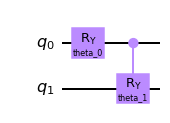

In [95]:
qc_test,par_list = gray_code_lim(1)
qc_test.draw('mpl')

In [96]:
#Tested for l=1,2,3,6,7,15
l_list_test = [1,2,3,6,7,15]

for l in l_list_test:
    print('l=',l)
    n_qubits =int(np.ceil(np.log2(2 * l+ 1)))
    qc_test,par_list = gray_code_lim(l)

    #qc_test.draw('mpl')#,filename='gray_code_lim_l1.png')

    circuit_physical(qc_test,n_qubits,len(par_list),fermions=False)

l= 1


  0%|          | 0/4 [00:00<?, ?it/s]

states reached: {'00', '11', '01'} states unphys: {'10'} states phys: {'00', '11', '01'}
all physical states reached : OK!
l= 2


  0%|          | 0/8 [00:00<?, ?it/s]

states reached: {'010', '000', '011', '001', '110'} states unphys: {'100', '111', '101'} states phys: {'010', '000', '011', '001', '110'}
all physical states reached : OK!
l= 3


  0%|          | 0/16 [00:00<?, ?it/s]

states reached: {'101', '010', '111', '000', '011', '001', '110'} states unphys: {'100'} states phys: {'101', '010', '111', '000', '011', '001', '110'}
all physical states reached : OK!
l= 6


  0%|          | 0/32 [00:00<?, ?it/s]

states reached: {'0110', '0101', '0001', '1101', '1100', '1111', '0111', '1110', '1010', '0000', '0100', '0010', '0011'} states unphys: {'1000', '1001', '1011'} states phys: {'0101', '0001', '1101', '1100', '1111', '0100', '0111', '1110', '1010', '0000', '0110', '0010', '0011'}
all physical states reached : OK!
l= 7


  0%|          | 0/64 [00:00<?, ?it/s]

states reached: {'0110', '0101', '1011', '0001', '1101', '1100', '1111', '0111', '1001', '1110', '1010', '0000', '0100', '0010', '0011'} states unphys: {'1000'} states phys: {'0101', '1011', '0001', '1101', '1100', '1111', '0100', '0111', '1001', '1110', '1010', '0000', '0110', '0010', '0011'}
all physical states reached : OK!
l= 15


  0%|          | 0/256 [00:00<?, ?it/s]

states reached: {'10100', '00010', '11010', '11111', '00001', '01101', '01011', '00101', '10001', '01010', '11000', '10101', '11001', '00111', '10011', '00100', '10010', '11110', '00110', '11011', '01001', '01000', '11100', '10110', '01100', '01111', '11101', '00000', '10111', '01110', '00011'} states unphys: {'10000'} states phys: {'10100', '00010', '11010', '11111', '00001', '01101', '01011', '00101', '10001', '01010', '11000', '10101', '00111', '11001', '10011', '00100', '10010', '11110', '00110', '11011', '01000', '01001', '11100', '10110', '01100', '01111', '11101', '00000', '10111', '01110', '00011'}
all physical states reached : OK!


ZERO TOTAL CHARGE FOR FERMIONS WITH ISWAP GATES

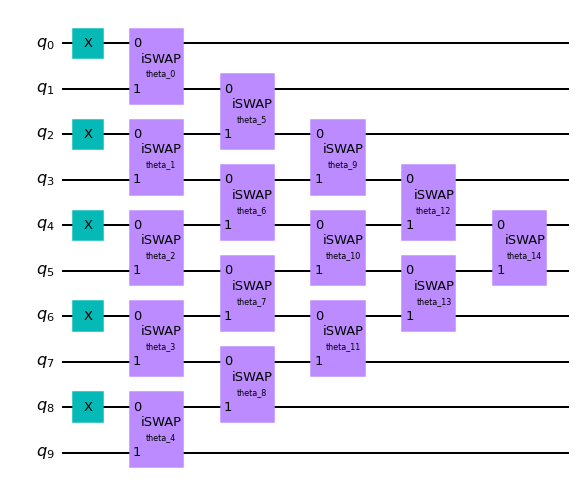

In [164]:
#fermion circuit proposal
p = Parameter('p')
qc = QuantumCircuit(2,name='iSWAP')
qc.rxx(p, 0, 1)
qc.ryy(p, 0, 1)


n_qubits_f = 10
qr = QuantumRegister(n_qubits_f,name='q')
qc_tot2 = QuantumCircuit(qr)

params = lambda i: Parameter(f'theta_{i}')

th=0
for i in range(0,n_qubits_f,2):
    qc_tot2.x(i)

for j in range(n_qubits_f//2):
    for i in range(j,n_qubits_f-j,2):
            qc_tot2.append(qc.to_instruction({p: params(th)}), qr[i:i+2])
            th+=1


qc_tot2.draw('mpl')

In [154]:
circuit_physical(qc_tot2,n_qubits_f,th,fermions=True)

  0%|          | 0/1024 [00:00<?, ?it/s]

all physical states reached : OK!


In [330]:
qc_tot2 = QuantumCircuit(2)
factor = np.pi/5
qc_tot2.rxx(factor, 0,1)
qc_tot2.ryy(factor, 0,1)
print(np.round(Operator(qc_tot2).to_matrix(),4))

[[1.   +0.j     0.   +0.j     0.   +0.j     0.   +0.j    ]
 [0.   +0.j     0.809+0.j     0.   -0.5878j 0.   +0.j    ]
 [0.   +0.j     0.   -0.5878j 0.809+0.j     0.   +0.j    ]
 [0.   +0.j     0.   +0.j     0.   +0.j     1.   +0.j    ]]


In [335]:
#Test with all parameters =pi/6
for n_qubits_f in range(2,12,2):
    qr = QuantumRegister(n_qubits_f,name='q')
    qc_tot2 = QuantumCircuit(qr)

    params = lambda i: Parameter(f'theta_{i}')

    th=0
    for i in range(0,n_qubits_f,2):
        qc_tot2.x(i)

    for j in range(n_qubits_f//2):
        for i in range(j,n_qubits_f-j,2):
                qc_tot2.append(qc.to_instruction({p: params(th)}), qr[i:i+2])
                th+=1
    # for k in range(n_qubits_f):
    #     qc_tot2.rz(th, k)
    #     th+=1
    #print(set([(key,val) for key,val in Statevector(qc_tot2.bind_parameters(dict(zip(qc_tot2.parameters,[np.pi/6,]*len(qc_tot2.parameters))))).probabilities_dict().items() if val>1e-16]))
    print(n_qubits_f,{''.join(i) for i in permutations(['0','1']*(n_qubits_f//2),n_qubits_f)} == set([key for key,val in Statevector(qc_tot2.bind_parameters(dict(zip(qc_tot2.parameters,[np.pi/6,]*len(qc_tot2.parameters))))).probabilities_dict().items() if val>1e-14]))

2 True
4 True
6 True
8 True
10 True


In [71]:
#Tested for up to 12 fermions. Parameter values 0=gate doesn't act or pi/2=gate acts RXX+RYY

n_qubits_f_list = range(2,12,2)
for n_qubits_f in n_qubits_f_list:
    print('n_qubits_f=',n_qubits_f)
    p = Parameter('p')
    qc = QuantumCircuit(2,name='iSWAP')
    qc.rxx(p, 0, 1)
    qc.ryy(p, 0, 1)

    qr = QuantumRegister(n_qubits_f)
    qc_tot2 = QuantumCircuit(qr)
    params = lambda i: Parameter(f'theta_{i}')

    th=0
    for i in range(0,n_qubits_f,2):
        qc_tot2.x(i)

    for j in range(n_qubits_f//2):
        for i in range(j,n_qubits_f-j,2):
                qc_tot2.append(qc.to_instruction({p: params(th)}), qr[i:i+2])
                th+=1

    circuit_physical(qc_tot2,n_qubits_f,th,fermions=True)

n_qubits_f= 2


  0%|          | 0/2 [00:00<?, ?it/s]

2 states reached: {'01', '10'} 2 fermions with zero charge: {'01', '10'}
all physical states reached : OK!
n_qubits_f= 4


  0%|          | 0/8 [00:00<?, ?it/s]

6 states reached: {'0101', '1100', '1001', '1010', '0110', '0011'} 6 fermions with zero charge: {'0101', '1100', '1001', '1010', '0110', '0011'}
all physical states reached : OK!
n_qubits_f= 6


  0%|          | 0/64 [00:00<?, ?it/s]

20 states reached: {'000111', '001101', '011100', '101010', '010101', '101001', '110100', '001110', '011010', '110010', '110001', '011001', '101100', '111000', '100011', '100101', '100110', '001011', '010011', '010110'} 20 fermions with zero charge: {'000111', '001101', '011100', '101010', '010101', '101001', '110100', '001110', '011010', '110010', '110001', '011001', '101100', '111000', '100011', '100101', '100110', '001011', '010011', '010110'}
all physical states reached : OK!
n_qubits_f= 8


  0%|          | 0/1024 [00:00<?, ?it/s]

all physical states reached : OK!
n_qubits_f= 10


  0%|          | 0/32768 [00:00<?, ?it/s]

all physical states reached : OK!


##### Hamiltonian

In [132]:
#class input parameters:
n_sites = [2,2]#how many sites for every dimension
g=1
fact_e_op = 1
fact_b_op = 1
m=0.1
omega=1
l=1
L=2
rotors = False
lambd = 1000
encoding = 'gray' ##'ed'#
magnetic_basis=False
pbc=False
puregauge = False 
static_charges_values =None#{(0,0):1,(1,0):-1}#TODO: no conditions applied, like charge conservation, etc. For conditions see func_qstatic_dist
display_hamiltonian=False
e_op_out_plus=False #if E out of site n has plus sign 
sparse_pauli =False #false for circuit ansatz
#exact diagonalisation parameters:
threshold = 1e-12
num_eigs = 2

In [133]:
latt = HCLattice(n_sites,pbc=pbc)

In [134]:
hamilt_sym = HamiltonianQED_sym(
                        latt,
                        n_sites,
                        l,
                        ll=L,
                        encoding = encoding,
                        rotors=rotors,
                        magnetic_basis=magnetic_basis,
                        pbc=pbc,
                        puregauge=puregauge,
                        static_charges_values=static_charges_values,
                        e_op_out_plus = e_op_out_plus,
                        display_hamiltonian=display_hamiltonian)

class_H_oprt = HamiltonianQED_oprt(
                        latt,
                        hamilt_sym,
                        n_sites,
                        l,
                        ll=L,
                        encoding = encoding,
                        rotors=rotors,
                        magnetic_basis=magnetic_basis,
                        pbc=pbc,
                        puregauge=puregauge,
                        static_charges_values=static_charges_values,
                        e_op_out_plus = e_op_out_plus,
                        sparse_pauli=sparse_pauli)

Alpha angle α=2 π/2L+1
HamiltonianQED_sym: Initializing...
>> Gauss law system of equations (symbolic + latex):
static charges: None


Eq(-E_00x - E_00y - q_00, 0)

Eq(E_00y - E_01x - q_01, 0)

Eq(E_00x - E_10y - q_10, 0)

Eq(E_01x + E_10y - q_11, 0)

Eq(q_00 + q_01 + q_10 + q_11, 0)

- E_{00x} - E_{00y} - q_{00} &= 0 \\ \nonumber
E_{00y} - E_{01x} - q_{01} &= 0 \\ \nonumber
E_{00x} - E_{10y} - q_{10} &= 0 \\ \nonumber
E_{01x} + E_{10y} - q_{11} &= 0 \\ \nonumber
q_{00} + q_{01} + q_{10} + q_{11} &= 0 

> Gauss law equations solved
> e_op_free and u_op_free built
>> Hamiltonian (symbolic + latex):


Eq(H_E, g**2*(E_10y**2 + (-E_10y + q_11)**2 + (E_10y + q_10)**2 + (-E_10y + q_01 + q_11)**2)/2)

H_{E} = \frac{g^{2} \left(E_{10y}^{2} + \left(- E_{10y} + q_{11}\right)^{2} + \left(E_{10y} + q_{10}\right)^{2} + \left(- E_{10y} + q_{01} + q_{11}\right)^{2}\right)}{2}


Eq(H_B, -(U_10y + h.c.)/(2*g**2))

H_{B} = - \frac{U_{10y} + h.c.}{2 g^{2}}


Eq(H_K, Omega*(0.5*I*(-h.c.(x) + Dagger(Phi_1)*Phi_2 + Dagger(Phi_4)*Phi_3) - 0.5*(h.c.(y) + Dagger(Phi_1)*Phi_4 - Dagger(Phi_2)*Dagger(U_10y)*Phi_3)))

H_{K} = \Omega \left(0.5 i \left(- h.c.(x) + \Phi_{1}^{\dagger} \Phi_{2} + \Phi_{4}^{\dagger} \Phi_{3}\right) - 0.5 \left(h.c.(y) + \Phi_{1}^{\dagger} \Phi_{4} - \Phi_{2}^{\dagger} U_{10y}^{\dagger} \Phi_{3}\right)\right)


Eq(H_m, m*(Dagger(Phi_1)*Phi_1 - Dagger(Phi_2)*Phi_2 + Dagger(Phi_3)*Phi_3 - Dagger(Phi_4)*Phi_4))

H_{m} = m \left(\Phi_{1}^{\dagger} \Phi_{1} - \Phi_{2}^{\dagger} \Phi_{2} + \Phi_{3}^{\dagger} \Phi_{3} - \Phi_{4}^{\dagger} \Phi_{4}\right)
>> Gauss law applied and Hamiltonian built.  Execution time: 0.10306620597839355 seconds
HamiltonianQED_oprt: Initializing...
> e_op_free and u_op_free built
> Pauli strings built
>> Hamiltonian built.  Execution time: 3.9877429008483887 seconds
>> Suppression term built.  Execution time: 0.0029981136322021484 seconds


##### ED spectrum for multiple couplings

In [352]:
#ED
import scipy.sparse as sp

In [353]:
g_list = np.linspace(0.5,5,10);g_list

array([0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ])

In [370]:
spectra = []
for g in g_list:
    Hamiltonian_Pauli_tot = class_H_oprt.get_hamiltonian(g_var=g, m_var=m, omega=omega,fact_b_op=fact_b_op,fact_e_op=fact_b_op,lambd=lambd)
    #memory sparse matrix
    #print((Hamiltonian_Pauli_tot.data.nbytes + Hamiltonian_Pauli_tot.indptr.nbytes + Hamiltonian_Pauli_tot.indices.nbytes)/1000**3,'Gb')
    if encoding=='gray' and not sparse_pauli:
        Hamiltonian_Pauli_tot = Hamiltonian_Pauli_tot.to_matrix(sparse=True)
        if ngauge:
            h_b_sparse = class_H_oprt.hamiltonian_mag_pauli.to_matrix(sparse=True) #plaquette
        else:
            h_b_sparse = 0 
    elif encoding=='ed':
        Hamiltonian_Pauli_tot = sp.csr_matrix(Hamiltonian_Pauli_tot)
        if ngauge:
            h_b_sparse =sp.csr_matrix(class_H_oprt.hamiltonian_mag_pauli)
        else:
            h_b_sparse =0

    #** Exact diagonalisation
    spectrum, eigenvectors_matrix =primme.eigsh(Hamiltonian_Pauli_tot,k=10,which="SA")#,ncv = 30)
    #spectrum
    idx = spectrum.argsort() 
    spectrum = spectrum[idx]
    eigenvectors_matrix = eigenvectors_matrix[:,idx]
    spectra.append(spectrum)

In [355]:
markers = [ 'o', 'v', '^', '<', '>', '1', '2', '3', '4', 's', 'p', '*', 'h', 'H', '+', 'x', 'D', 'd', '|', '_']

Text(0.5, 1.0, 'Energies for range of coupling g: 2 lattice, l=1, L=2, magnetic_basis=False, pbc=True, puregauge=False, m=1, omega=1')

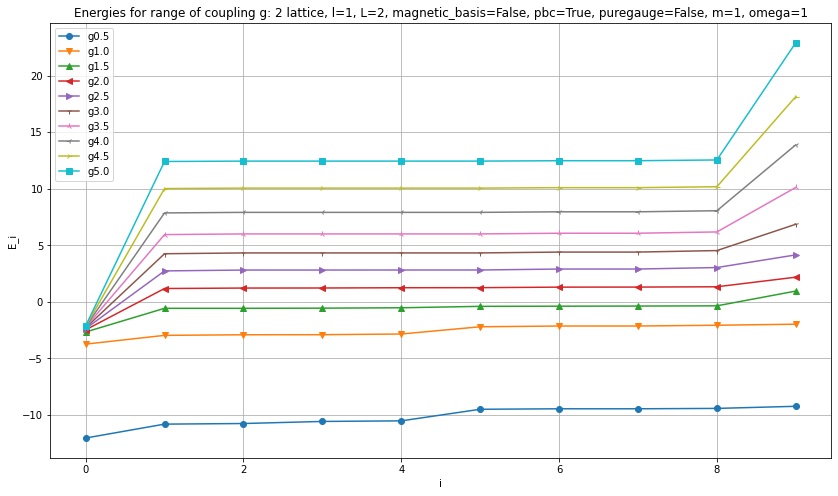

In [363]:
fig=plt.figure(figsize=(14, 8))
[plt.plot(i, marker=j, label=f'g{np.round(g,3)}') for i,j,g in zip(spectra,markers,g_list)]
plt.legend()
plt.grid()
plt.xlabel('i')
plt.ylabel('E_i')
plt.title(f'Energies for range of coupling g: {latt.dims} lattice, l={l}, L={L}, magnetic_basis={magnetic_basis}, pbc={pbc}, puregauge={puregauge}, m={m}, omega={omega}')

##### Lattice system

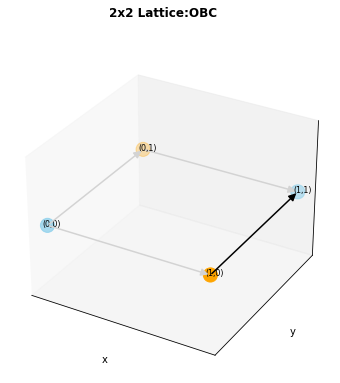

In [84]:

#latt.draw_graph_func(gauss_law_fig=False,static_charges=static_charges_values)
#only dynamical fields after Gauss law applied
latt.draw_graph_func(gauss_law_fig=True,e_op_free=class_H_oprt.e_op_free)#,savefig_dir='.')

In [85]:
class_H_oprt.phiop_list[::-1]+class_H_oprt.uop_list[::-1]#order of operators in tensor product and on circuit little endian ..q2q1q0

[Phi_4, Phi_3, Phi_2, Phi_1, U_10y]

In [86]:
for i,k in enumerate(class_H_oprt.uop_list+class_H_oprt.phiop_list):
    print(f'qubit{i}:{k}') 

qubit0:U_10y
qubit1:Phi_1
qubit2:Phi_2
qubit3:Phi_3
qubit4:Phi_4


In [87]:
for i,k in enumerate(class_H_oprt.uop_list+class_H_oprt.qop_list):
    print(f'qubit{i}:{k}') 

qubit0:U_10y
qubit1:q_00
qubit2:q_10
qubit3:q_11
qubit4:q_01


##### Composite circuit

In [11]:
# #ansatz pure gauge no entanglement
# nlayers = 1#TODO ATTENTION: selection of only physical states work only for nlayers=1
# ngauge = class_H_oprt.len_e_op
# nsites = 0#TODO add fermionic part
# n_qubits =int(np.ceil(np.log2(2 * l+ 1)))
# qc_tot = QuantumCircuit(n_qubits*ngauge+nsites)


# th=0
# #first gauge field
# qcc,lst = gray_code_lim(l,theta=th,layers=nlayers)
# qc_tot.compose(qcc,list(range(n_qubits)),inplace=True)

# for i in range(1,ngauge):#for the other gauge fields
#     theta = int(''.join(list(filter(str.isdigit, str(lst[-1])))))
#     qcc,lst = gray_code_lim(l,theta=theta+1,layers=nlayers)
#     qc_tot.compose(qcc,list(range(n_qubits*i,n_qubits*(i+1))),inplace=True)

# th=int(''.join(list(filter(str.isdigit, str(lst[-1])))))+1
# qc_tot.barrier()

# #**entanglement**
# #between the gauge fields
# # for i in range(n_qubits):
# #     for j in range(n_qubits,n_qubits*ngauge):
# #         qc_tot.cx(i,j)

# #linear entanglement cx gates
# # for i in range(n_qubits*ngauge-1):
# #     qc_tot.cx(i,i+1)


# #full entanglement cx gates
# # for i in range(n_qubits*ngauge):
# #     for j in range(i+1,n_qubits*ngauge):
# #         qc_tot.cx(i,j)

# #qc_tot.draw('mpl')#,filename='gray_code_lim_l1.png')

qc=QuantumCircuit(2)
qc.x(0)
Operator(qc).to_matrix() #from circuit to matrix
array([[0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
       [1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
       [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j]])

In [19]:
ngauge = class_H_oprt.len_e_op
if puregauge:
    n_qubits_f = 0
else:
    n_qubits_f = np.prod(latt.n_sites)#TODO add fermionic part

n_qubits =int(np.ceil(np.log2(2 * l+ 1)))

In [20]:
ansatz_class = Ansatz(l,ngauge,nfermions=4)

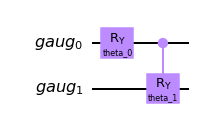

In [24]:
#qferm = QuantumRegister(n_qubits_f,name='ferm')
qgaug = QuantumRegister(n_qubits*ngauge,name='gaug')
qc_tot2 = QuantumCircuit(qgaug)

qc_tot2.compose(ansatz_class.qc_gauge,qgaug,inplace=True)
qc_tot2.draw('mpl')

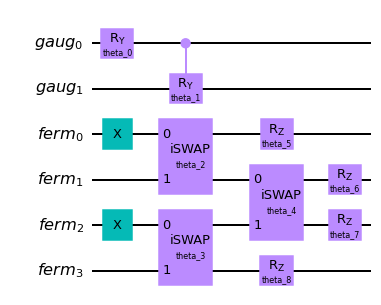

In [148]:
#ansatz full entanglement
nlayers = 1#TODO option more layers?
nlayers_f = 1
ngauge = class_H_oprt.len_e_op
if puregauge:
    n_qubits_f = 0
else:
    n_qubits_f = np.prod(latt.n_sites)#TODO add fermionic part

n_qubits =int(np.ceil(np.log2(2 * l+ 1)))

qferm = QuantumRegister(n_qubits_f,name='ferm')
qgaug = QuantumRegister(n_qubits*ngauge,name='gaug')
qc_tot2 = QuantumCircuit(qgaug,qferm)

th=0
#gauge part
if ngauge:
    qcc,lst = gray_code_lim(l,theta=th,layers=nlayers)
    #first gauge field
    qc_tot2.compose(qcc,list(range(n_qubits)),inplace=True)
    # qc_tot2.barrier()
    th=int(''.join(list(filter(str.isdigit, str(lst[-1])))))+1

    for i in range(1,ngauge):
        qc_tot2.ry(Parameter(f'theta_{th}'),n_qubits*i)
        th+=1
        for j in range(n_qubits*i):
            qc_tot2.cry(Parameter(f'theta_{th}'),j,n_qubits*i)
            th+=1
        # qc_tot2.barrier()
        qc_tot2.cry(Parameter(f'theta_{th}'),n_qubits*i,n_qubits*i+1)
        th+=1
        # qc_tot2.barrier()
        #multi-controlled gates
        for j in range(n_qubits*i):
            qc_tot2.mcry(Parameter(f'theta_{th}'),[j,n_qubits*i],n_qubits*i+1)
            th+=1

#fermion circuit proposal
p = Parameter('p')
qc = QuantumCircuit(2,name='iSWAP')
qc.rxx(p, 0, 1)
qc.ryy(p, 0, 1)


params = lambda i: Parameter(f'theta_{i}')

#th=0

for i in range(0,n_qubits_f,2):
    qc_tot2.x(qferm[i])
for nl in range(nlayers_f):
    for j in range(n_qubits_f//2):
        for i in range(j,n_qubits_f-j,2):
            qc_tot2.append(qc.to_instruction({p: params(th)}), qferm[i:i+2])
            th+=1

#last layer of Rz gates for correct phase
# for i in range(ngauge*n_qubits):
#     qc_tot2.rz(Parameter(f'theta_{th}'),i)
#     th+=1
for i in range(n_qubits_f):
    qc_tot2.rz(Parameter(f'theta_{th}'),qferm[i])
    th+=1
    
qc_tot2.draw('mpl')#,filename='gray_code_lim_l1.png')
#qc_tot2.decompose().draw('mpl')

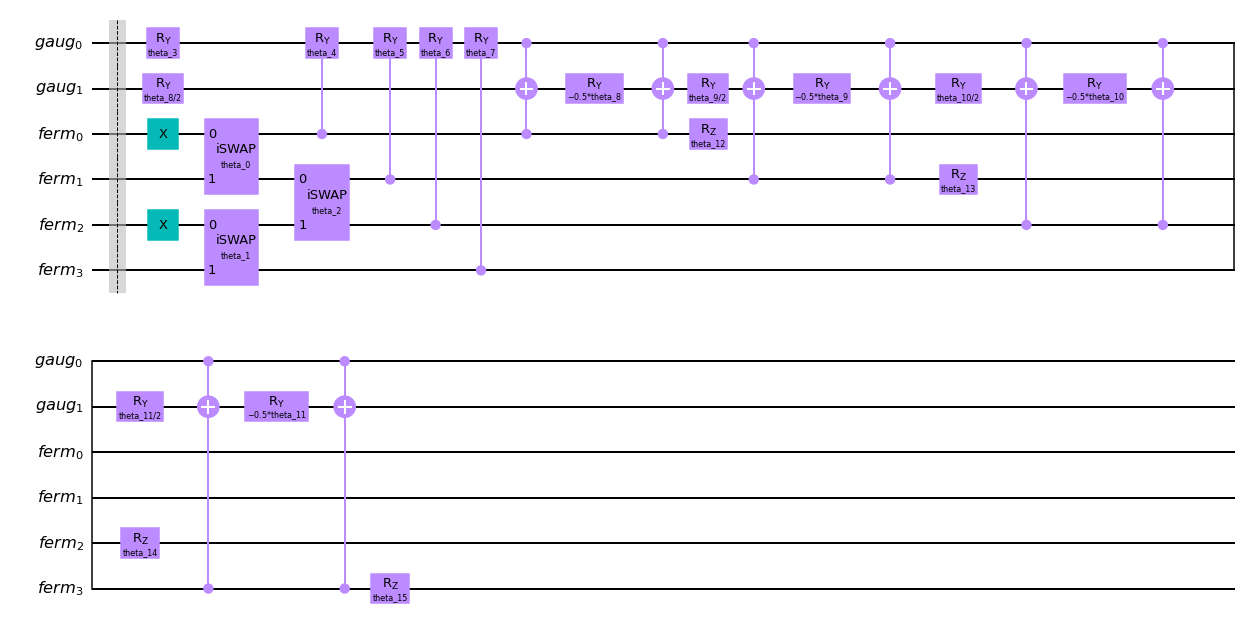

In [159]:
#ansatz entanglement
nlayers = 1#TODO option more layers?
ngauge = class_H_oprt.len_e_op
if puregauge:
    n_qubits_f = 0
else:
    n_qubits_f = np.prod(latt.n_sites)#TODO add fermionic part

n_qubits =int(np.ceil(np.log2(2 * l+ 1)))

qferm = QuantumRegister(n_qubits_f,name='ferm')
qgaug = QuantumRegister(n_qubits*ngauge,name='gaug')
qc_tot2 = QuantumCircuit(qgaug,qferm)

th=0


qc_tot2.barrier()
#fermion circuit proposal
p = Parameter('p')
qc = QuantumCircuit(2,name='iSWAP')
qc.rxx(p, 0, 1)
qc.ryy(p, 0, 1)
#qc.rzz(p, 0, 1)#TODO: only for NFT optimizer
params = lambda i: Parameter(f'theta_{i}')

#th=0
for i in range(0,n_qubits_f,2):
    qc_tot2.x(qferm[i])

for j in range(n_qubits_f//2):
    for i in range(j,n_qubits_f-j,2):
            qc_tot2.append(qc.to_instruction({p: params(th)}), qferm[i:i+2])
            th+=1

#gauge part
qc_tot2.ry(Parameter(f'theta_{th}'),0)
th+=1
#entangling with fermions 1st option
for j in range(2,6):
    qc_tot2.cry(Parameter(f'theta_{th}'),j,0)
    th+=1

# qc_tot2.cry(Parameter(f'theta_{th}'),3,0)
# th+=1
# qc_tot2.cry(Parameter(f'theta_{th}'),4,0)
# th+=1


# qc_tot2.cry(Parameter(f'theta_{th}'),0,1)
# th+=1

# qc_tot2.mcry(Parameter(f'theta_{th}'),[0,3],1)
# th+=1
# qc_tot2.mcry(Parameter(f'theta_{th}'),[0,4],1)
# th+=1

#entangling with fermions 1st option
for j in range(2,6):
    qc_tot2.mcry(Parameter(f'theta_{th}'),[0,j],1)
    th+=1


# for i in range(ngauge*n_qubits):
#     qc_tot2.rz(Parameter(f'theta_{th}'),i)
#     th+=1

for i in range(n_qubits_f):
    qc_tot2.rz(Parameter(f'theta_{th}'),qferm[i])
    th+=1

qc_tot2.draw('mpl')#,filename='gray_code_lim_l1.png')
#qc_tot2.decompose().draw('mpl')

In [14]:
qc_tot2.depth()

97

##### ED

In [89]:
#ED

import scipy.sparse as sp
Hamiltonian_Pauli_tot = class_H_oprt.get_hamiltonian(g_var=g, m_var=m, omega=omega,fact_b_op=fact_b_op,fact_e_op=fact_b_op,lambd=lambd)
#memory sparse matrix
#print((Hamiltonian_Pauli_tot.data.nbytes + Hamiltonian_Pauli_tot.indptr.nbytes + Hamiltonian_Pauli_tot.indices.nbytes)/1000**3,'Gb')
if encoding=='gray' and not sparse_pauli:
    Hamiltonian_Pauli_tot = Hamiltonian_Pauli_tot.to_matrix(sparse=True)
    if ngauge:
        h_b_sparse = class_H_oprt.hamiltonian_mag_pauli.to_matrix(sparse=True) #plaquette
    else:
        h_b_sparse = 0 
elif encoding=='ed':
    Hamiltonian_Pauli_tot = sp.csr_matrix(Hamiltonian_Pauli_tot)
    if ngauge:
        h_b_sparse =sp.csr_matrix(class_H_oprt.hamiltonian_mag_pauli)
    else:
        h_b_sparse =0

#** Exact diagonalisation
spectrum, eigenvectors_matrix =primme.eigsh(Hamiltonian_Pauli_tot,k=num_eigs,which="SA")#,ncv = 30)
#spectrum
idx = spectrum.argsort() 
spectrum = spectrum[idx]
eigenvectors_matrix = eigenvectors_matrix[:,idx]

ed_val = []
for kk in range(num_eigs):
    ed_val.append(dict([(str(np.binary_repr(i, width = (ngauge*n_qubits+n_qubits_f))),np.abs(eigenvectors_matrix[:,kk][i])**2) for i in range(2**(ngauge*n_qubits+n_qubits_f)) if np.abs(eigenvectors_matrix[:,kk][i])**2>1e-10]))

eig0cj = sp.csr_matrix(eigenvectors_matrix[:,0]).transpose().conjugate()
eig0= sp.csr_matrix(eigenvectors_matrix[:,0])
if ngauge:
    plaq = (eig0*h_b_sparse*eig0cj/len(latt.plaq_list) ).toarray()[0][0].real

print('spectrum ED:',spectrum)

spectrum ED: [-1.29267704  0.06142416]


##### Input parameteres circuit

2D_2x2mbasisFalse puregaugeTrue g0.1 pbcTrue l1_factE1_factB1_m3_Omega1 nlayers1 iterations[500, 500] optimizerSLSQP:

in. point

array([ 0.2018109 ,  0.24488692,  0.21166536,  0.2827267 ,  0.57939206,
        0.0510488 , -0.60911057,  0.58872647, -0.59156033,  0.63703664,
        0.6161558 ,  0.32709866, -0.14901505,  0.25207003, -0.59671775,
        0.55807236,  0.17197293, -0.29482396, -0.71963126, -0.48101984,
        0.69696426,  0.21615586,  0.19234214, -0.71834603, -0.75412552,
       -0.51238705, -0.35319082,  0.35969965, -0.39224147,  0.48351348,
        0.40515203, -0.52143608,  0.15010049, -0.62242227, -0.49699271,
       -0.66024822, -0.74409014, -0.34114466,  0.49847996, -0.47393087,
       -0.38242287,  0.06001916,  0.5692371 , -0.00607085, -0.00131586,
        0.55668509,  0.24684299, -0.50486786,  0.38434161, -0.29313127])

#test con 5 itrs per E0, initial point=[best parameters di E0, random per E1] visto che ok risultato. improvement for E1
initial_point=np.array([ 3.14154162e+00,  5.72623979e-04,  2.17575153e-01, -4.43899343e+00,
       -2.52326329e-02, -8.52384728e-01,  9.72301363e-01,  2.53065378e-01,
       -1.19903100e-01, -3.68589042e-01, -4.41354980e+00,  9.60270708e-01,
       -3.34982139e-01,  3.80935810e-01, -8.61384447e-01, -4.69209243e-01,
        1.17306594e+00,  3.26564763e-01,  4.72398075e-01, -3.80842210e-01,
        4.03939615e-01, -4.44077834e-02, -7.74449354e-01, -2.80660656e+00,
       -4.71371794e-02, -3.93666626e-01,  5.00971380e+00, -2.47171242e-01,
       -2.80326076e-01, -1.60553159e+00,  2.25608451e-01, -1.15995150e+00,
       -8.50900211e-01,  1.14454655e+00,  3.60792093e-01,  6.70696852e-02,
       -1.10024490e+00, -1.54467799e-01,  1.65335541e-01,  1.13584008e+00,
       -4.67075197e-01,  4.10233323e-01,  4.18324225e-01, -2.91362996e-01,
       -2.09179246e-01,  3.83636545e-02, -3.83597141e-02,  4.95250596e-01,
        3.30578886e+00, -2.00839239e+00])

In [160]:
#Input parameters for VQD
estimator = Estimator()
sampler = Sampler()
fidelity = ComputeUncompute(sampler)

iterations = [200 for i in range(num_eigs)]
optimizer = [SLSQP(maxiter=itr) for itr in iterations] #SLSQP,COBYLA  #TODO: with NFT iSWAPS with also Rzz gates
ansatz = qc_tot2
betas = [2,]*(num_eigs-1)  #***default value computed as the mean square sum of the coefficients of the observable.
val_init = np.pi/4

#initial_point=[val_init*(2*np.random.rand(ansatz.num_parameters)-1.0) for kkk in range(num_eigs)]
initial_point=val_init*(2*np.random.rand(ansatz.num_parameters)-1.0) 

aux_operators =[class_H_oprt.hamiltonian_mag_pauli,] if ngauge else None

Hamiltonian_Pauli_tot_vqd = class_H_oprt.get_hamiltonian(g_var=g, m_var=m, omega=omega,fact_b_op=fact_b_op,fact_e_op=fact_b_op,lambd=0)

In [75]:
#initial_point = [np.array(list(result.optimal_parameters[0].values())),]+[val_init*(2*np.random.rand(ansatz.num_parameters)-1.0) for kkk in range(num_eigs-1)]

##### Entropy of lattice

entropy E_0
entropy E_1
circuits entropy


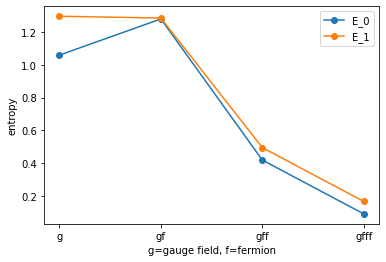

In [106]:
#****Entropy ED: between the gauge fields only (not internal qubits)
n_qubits_tot = ngauge*n_qubits+n_qubits_f
ntot_rev = list(range(n_qubits_tot))[::-1]

S_ed_list = []
for k in range(num_eigs):
    print(f'entropy E_{k}')
    s_tmp = []
    for i in range(ngauge-1):
        S_ed = entropy(qinf.partial_trace(DensityMatrix(eigenvectors_matrix[:,k]), ntot_rev[:(i+1)*n_qubits][::-1]))#list(range(0,(i+1)*n_qubits))))
        #print('A=',list(range(0,(i+1)*n_qubits)),'S=',S_ed)#'B=',list(range((i+1)*n_qubits,ngauge*n_qubits)),
        s_tmp.append(S_ed)
    if ngauge:
        start_f = ngauge*n_qubits
    else:
        start_f = 1
    for i in range(start_f,n_qubits_tot):
        S_ed = entropy(qinf.partial_trace(DensityMatrix(eigenvectors_matrix[:,k]),ntot_rev[:i][::-1]))# list(range(i))))
        #print('A=',list(range(i)),'S=',S_ed)#'B=',list(range((i+1)*n_qubits,ngauge*n_qubits)),
        s_tmp.append(S_ed)

    S_ed_list.append(s_tmp)
print('circuits entropy')
#circuit, tried with some values of thetas
# circ = qc_tot2
# for i in range(ngauge-1):
#     print('S=',[np.round(entropy(qinf.partial_trace(DensityMatrix(circ.bind_parameters([np.pi/p]*circ.num_parameters )), list(range(0,(i+1)*n_qubits)))),5) for p in [0.25,0.5,1,2,4]])

from itertools import accumulate
custom_labels = ['g']*ngauge+['f']*(n_qubits_f-1)
custom_labels = [''.join(custom_labels[:i+1]) for i, _ in enumerate(accumulate(custom_labels))]
x_values = list(range(ngauge+n_qubits_f-1))
[plt.plot(val,marker='o',label=f'E_{j}') for j,val in enumerate(S_ed_list)]
plt.xticks(x_values, custom_labels)
plt.ylabel('entropy')
plt.xlabel('g=gauge field, f=fermion')
plt.legend()

In [ ]:
# for i in range(ngauge-1):
#    print([np.round(entropy(qinf.partial_trace(DensityMatrix(qc_tot2.bind_parameters([np.pi/p]*qc_tot2.num_parameters )), ntot_rev[:(i+1)*n_qubits][::-1])),5) for p in [0.25,0.5,1,2,4]])

#    if ngauge:
#       start_f = ngauge*n_qubits
#    else:
#       start_f = 1
# for i in range(start_f,n_qubits_tot):
#    print([np.round(entropy(qinf.partial_trace(DensityMatrix(qc_tot2.bind_parameters([np.pi/p]*qc_tot2.num_parameters )), ntot_rev[:i][::-1])),5) for p in [0.25,0.5,1,2,4]])
    

##### VQD

In [161]:


#callback function
E_data = [[] for k in range(num_eigs)]
Fidelity = [[] for k in range(num_eigs)]
def callback(eval_count, parameters, mean, meta, step):
    stdout.write("eig: %d/%d -> its %4d \r"%(step,num_eigs,eval_count)) # assuming SPSA
    stdout.flush()

    #fidelity
    vqd_states = [ansatz.bind_parameters(parameters) for i in range(num_eigs)]
    vqd_fid_states =[qinf.Statevector.from_instruction(i) for i in vqd_states]
    ed_fid_states =[Statevector(eigenvectors_matrix[:,i]) for i in range(num_eigs)]
    Fidelity[step-1].append([qinf.state_fidelity(vqd,ed) for vqd,ed in zip(vqd_fid_states,ed_fid_states)])

    #energy
    E_data[step-1].append([len(E_data[step-1]),mean,meta])

#Perform VQD for Hamiltonian and plaquette operator
vqd = VQD(estimator, fidelity, ansatz, optimizer, k=num_eigs, betas=betas,initial_point=initial_point,  callback=callback)
result = vqd.compute_eigenvalues(operator = Hamiltonian_Pauli_tot_vqd,aux_operators = aux_operators)# Hamiltonian + auxiliary operator
vqd_values = result.eigenvalues

#eigenvectors
vqd2_eigenstates = []
for i in range(num_eigs):
    tmp = result.optimal_circuits[i].copy()
    
    tmp.measure_all()
    opt_pt =list(result.optimal_parameters[i].values())
    res = sampler.run(tmp, opt_pt).result() 
    
    vqd2_eigenstates.append({x:round(y,6) for x,y in res.quasi_dists[0].binary_probabilities().items() if y>0.0001})
    tmp.remove_final_measurements()

if ngauge:
    plaq_vqd = np.array(result.aux_operators_evaluated[0])[:,0][0]/len(latt.plaq_list)

In [162]:


print(f'E_i ED vs VQD test:{latt.dims}D_'+'x'.join(map(str,latt.n_sites))+f'mbasis{magnetic_basis} puregauge{puregauge} g{g} pbc{pbc} l{l}_factE{fact_e_op}_factB{fact_b_op}_m{m}_Omega{omega} nlayers{nlayers} iterations{iterations} optimizer'+
[i for i in ['NFT','SLSQP','COBYLA','ADAM','SPSA','GradientDescent'] if i in str(optimizer[0])][0])

#** Print results
for kk,evalu in enumerate(spectrum):
        if evalu<900:# only physical states, 1000 corresponds to factor of penalty term
            print(f'E_{kk}(ED)=',round(evalu,8))#,[(str(np.binary_repr(i, width = (ngauge*n_qubits))),round(np.abs(eigenvectors_matrix[:,kk][i])**2,6)) for i in range(2**(ngauge*n_qubits)) if np.abs(eigenvectors_matrix[:,kk][i])**2>1e-4])
            print(f'E_{kk}(VQD)=',vqd_values.real[kk])#,vqd2_eigenstates[kk])

#** Plaquette operator
print('\n','Plaq. ED:',plaq,'Plaq. VQD:',plaq_vqd.real,'\n')

# #** Fidelity final
fid=fidelity_func(result,eigenvectors_matrix,num_eigs)
print('Fidelity (|psi_VQDXpsi_ED|^2):')
[print(f'E_{i}:',fd) for i,fd in enumerate(fid)]


#**Check if there are unphysical states
gray_unph = []
for i in range(2 * l + 1, 2**int(np.ceil(np.log2(2 * l+ 1)))):
    gray_decimal = i ^ (i >> 1)
    gray_unph.append("{0:0{1}b}".format(gray_decimal,int(np.ceil(np.log2(2 * l+ 1)))))  

ferm_q0 = [''.join(i) for i in permutations(['0','1']*(n_qubits//2),n_qubits)]

print('Check if in VQD sol. there are unphysical states: Gauge fields:',gray_unph,'Fermions: only zero charge are considered physical')
for i in range(num_eigs):
    if ngauge:
        for vqd_res in [string[-(ngauge*n_qubits):][i:i+int(np.ceil(np.log2(2 * l+ 1)))] for string in vqd2_eigenstates[i].keys() for i in range(0, len(string[-(ngauge*n_qubits):]), int(np.ceil(np.log2(2 * l+ 1))))]:
            if vqd_res in gray_unph:
                print('unphysical state reached for gauge fields')
                break
        else:   
            print(f'E_{i} all physical states reached gauge fields: OK!')
    if n_qubits_f:
        for vqd_res in [string[:n_qubits_f] for string in vqd2_eigenstates[i].keys() ]:

            if vqd_res in ferm_q0:
                print('unphysical state reached for fermions')
                break
        else:   
            print(f'E_{i} all physical states reached fermions: OK!')


E_i ED vs VQD test:2D_2x2mbasisFalse puregaugeFalse g1 pbcFalse l1_factE1_factB1_m0.1_Omega1 nlayers1 iterations[200, 200] optimizerSLSQP
E_0(ED)= -1.29267704
E_0(VQD)= -1.055938361229984
E_1(ED)= 0.06142416
E_1(VQD)= -0.18883948827037808

 Plaq. ED: 0.4477244682820555 Plaq. VQD: 0.41178426803651225 

Fidelity (|psi_VQDXpsi_ED|^2):
E_0: 0.8385336711515835
E_1: 0.24062540816429423
Check if in VQD sol. there are unphysical states: Gauge fields: ['10'] Fermions: only zero charge are considered physical
E_0 all physical states reached gauge fields: OK!
E_0 all physical states reached fermions: OK!
E_1 all physical states reached gauge fields: OK!
E_1 all physical states reached fermions: OK!


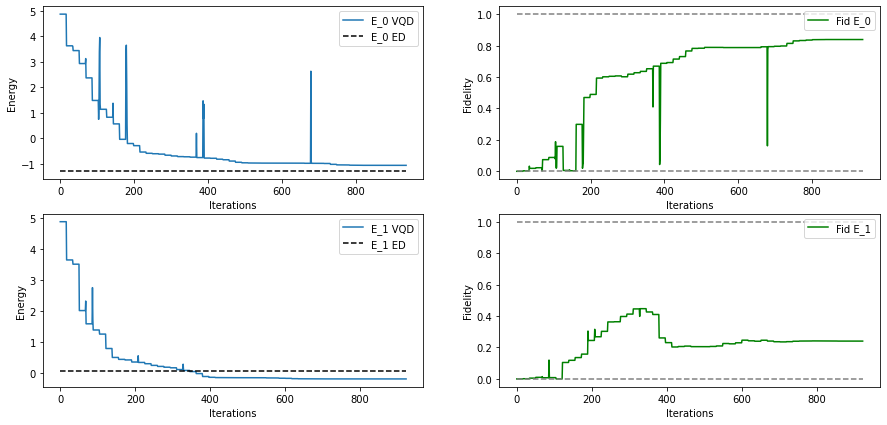

In [163]:

fig,axes = plt.subplots(num_eigs,2,figsize=(15,7))

for k in range(num_eigs):
    #Energy
    axes[k][0].plot([i[0] for i in E_data[k]],[i[1] for i in E_data[k]],label=f'E_{k} VQD')
    axes[k][0].hlines(spectrum[k],0,E_data[k][-1][0],linestyles='dashed',color='black',label=f'E_{k} ED')

    #Fidelity
    axes[k][1].plot([i[0] for i in E_data[k]],[i[k] for i in Fidelity[k]],label=f'Fid E_{k}',color='green')
    #fidelity max value 1 and min 0
    axes[k][1].hlines(1,0,E_data[k][-1][0],linestyles='dashed',color='gray')
    axes[k][1].hlines(0,0,E_data[k][-1][0],linestyles='dashed',color='gray')

    axes[k][0].set_ylabel('Energy')
    axes[k][1].set_ylabel('Fidelity')

    for i in range(2):
        axes[k][i].set_xlabel('Iterations')
        axes[k][i].legend()

#fig.savefig('ansatz_tests/'+f'Energy_Fidelity_ED_vs_VQD_test:{latt.dims}D_'+'x'.join(map(str,latt.n_sites))+f'mbasis{magnetic_basis}_puregauge{puregauge}_g{g}_pbc{pbc}_l{l}_nlayers{nlayers}_iterations{iterations}.png')

##### Fidelity 

spectrum ED:


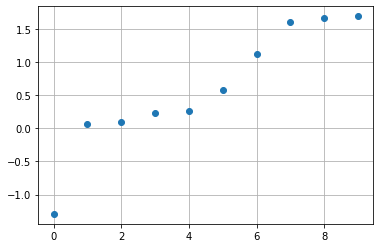

In [123]:
spectrum_fid, eigenvectors_matrix_fid =primme.eigsh(Hamiltonian_Pauli_tot,k=10,which="SA")#,ncv = 30)
#spectrum_fid
idx = spectrum_fid.argsort() 
spectrum_fid = spectrum_fid[idx]
eigenvectors_matrix_fid = eigenvectors_matrix_fid[:,idx]
print(f'spectrum ED:')
#print([f'E_{n}={np.round(i,5)}' for n,i in enumerate(spectrum_fid)])
plt.plot(spectrum_fid,'o',label='ED')
plt.grid()

In [124]:
print('fidelity overlap of 1st excited state with 1-4th excited states')
[print(f'E_{i}: val={np.round(spectrum_fid[i],6)}, fidelity: {np.round(fidelity_func_e(result,eigenvectors_matrix_fid,i,1),5)}') for i in range(1,9)]
print('\n sum of fid.: ',sum([fidelity_func_e(result,eigenvectors_matrix_fid,i,1) for i in range(1,9)]))

fidelity overlap of 1st excited state with 1-4th excited states
E_1: val=0.061424, fidelity: 0.06826
E_2: val=0.093058, fidelity: 0.49447
E_3: val=0.227196, fidelity: 1e-05
E_4: val=0.257281, fidelity: 0.27837
E_5: val=0.572281, fidelity: 0.0
E_6: val=1.121207, fidelity: 0.00256
E_7: val=1.59778, fidelity: 0.00083
E_8: val=1.662195, fidelity: 2e-05

 sum of fid.:  0.8445234445160656


Overlap with other states

Text(0.5, 0.98, 'Fidelity overlap of kth excited state with 1-8th excited states')

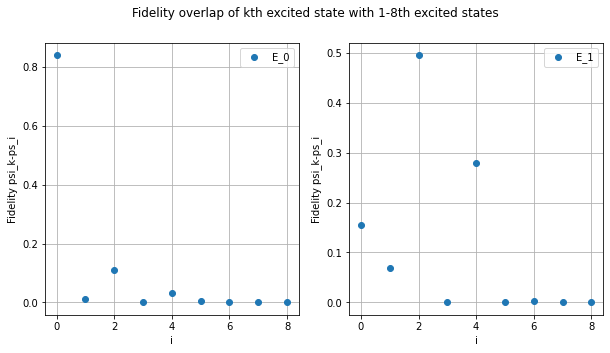

In [125]:
fig,ax = plt.subplots(1,num_eigs,figsize=(10,5))

for k in range(num_eigs):
    ax[k].plot([fidelity_func_e(result,eigenvectors_matrix_fid,i,k) for i in range(9)],'o',label=f'E_{k}')

    ax[k].grid()
    ax[k].legend()
    ax[k].set_xlabel('i')
    ax[k].set_ylabel('Fidelity psi_k-ps_i')

fig.suptitle('Fidelity overlap of kth excited state with 1-8th excited states')

In [1115]:
index = 1 #E_i eigenstate
initial_point=val_init*(2*np.random.rand(ansatz.num_parameters)-1.0) 

In [1088]:
#compute minimization of infidelity for index-th eigenstate

#callback function
E_data_vqe = []
def callback_vqe(eval_count, parameters, mean, meta):

    stdout.write("eig: %d -> its %4d \r"%(index,eval_count)) # assuming SPSA
    stdout.flush()
    #energy
    E_data_vqe.append([len(E_data_vqe),mean,meta])
    
#define infidelity as operator: id-|psi_ed_i><psi_ed_i| where i is a chosen eigenstate
test_fid = class_H_oprt.tensor_prod(class_H_oprt.I,6)- SparsePauliOp.from_operator( Operator(np.outer(eigenvectors_matrix[:,index],eigenvectors_matrix[:,index].transpose().conj())) )
#perform VQE with infidelity operator and ansatz
vqd_inf = VQE(estimator,  ansatz, optimizer=SLSQP(maxiter=500), initial_point=initial_point,callback=callback_vqe)
result_inf = vqd_inf.compute_minimum_eigenvalue(operator = test_fid)

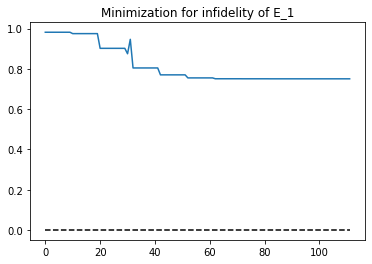

In [1089]:
plt.plot(np.array(E_data_vqe)[:,0],np.array(E_data_vqe)[:,1])
plt.title(f'Minimization for infidelity of E_{index}')
plt.hlines(0,0,E_data_vqe[-1][0],linestyles='dashed',color='black',label=f'E_{index} ED')

In [1090]:
print('fidelity=',1-result_inf.eigenvalue.real)

fidelity= 0.24924119314798965


In [1091]:
qinf.state_fidelity(Statevector(eigenvectors_matrix[:,1]),qinf.Statevector.from_instruction(result_inf.optimal_circuit.bind_parameters(result_inf.optimal_parameters.values()).to_instruction()))

0.24924119314813425

In [1092]:
fidelity_func(result,eigenvectors_matrix,num_eigs)

[0.9954160873396672,
 0.2492412291633147,
 0.49999999055867306,
 2.3145052192570552e-09]

##### Histograms

In [172]:
class_H_oprt.str_to_tens('00')

array([1, 0, 0, 0])

array([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j])

In [190]:
#action of E field
print(class_H_oprt.e_oper.to_matrix()@class_H_oprt.str_to_tens('00'),class_H_oprt.e_oper.to_matrix()@class_H_oprt.str_to_tens('01'),class_H_oprt.e_oper.to_matrix()@class_H_oprt.str_to_tens('11'))
print('vacuum E|01>=0|01>')
#action of charges
q10 = -0.5 * (class_H_oprt.I + class_H_oprt.Z).to_matrix()
q00 = 0.5 * (class_H_oprt.I - class_H_oprt.Z).to_matrix()

print(class_H_oprt.str_to_tens('0'),class_H_oprt.str_to_tens('1'))
print('even sites q - 0:', (q00@class_H_oprt.str_to_tens('0')).real,'q - 1:',(q00@class_H_oprt.str_to_tens('1')).real)
print('odd sites q - 0:',(q10@class_H_oprt.str_to_tens('0')).real,'q - 1:',(q10@class_H_oprt.str_to_tens('1')).real)

print('vacuum ..q2q1q0:1010')

[-1.+0.j  0.+0.j  0.+0.j  0.+0.j] [0.+0.j 0.+0.j 0.+0.j 0.+0.j] [0.+0.j 0.+0.j 0.+0.j 1.+0.j]
vacuum E|01>=0|01>
[1, 0] [0, 1]
even sites q - 0: [0. 0.] q - 1: [0. 1.]
odd sites q - 0: [-1.  0.] q - 1: [0. 0.]
vacuum ..q2q1q0:1010


In [217]:
def from_str_to_charges(str):
    """Return a string of particles configuration e+,e- or vacuum v
    Input a binary string of 0 and 1"""

    result = ''
    for i,q in enumerate(str):
        if i%2==0 and q=='0':
            result+='v'
        elif i%2==0 and q=='1':
            result+='e+'
        elif i%2==1 and q=='0':
            result+='e-'
        elif i%2==1 and q=='1':
            result+='v'
            
    return result



In [219]:
print([(s,from_str_to_charges(s)) for s in [''.join(i) for i in permutations(['0','1']*(int(n_qubits_f)//2),int(n_qubits_f))]])

[('0101', 'vvvv'), ('0110', 'vve+e-'), ('0011', 've-e+v'), ('0011', 've-e+v'), ('0110', 'vve+e-'), ('0101', 'vvvv'), ('1001', 'e+e-vv'), ('1010', 'e+e-e+e-'), ('1001', 'e+e-vv'), ('1010', 'e+e-e+e-'), ('1100', 'e+vve-'), ('1100', 'e+vve-'), ('0011', 've-e+v'), ('0011', 've-e+v'), ('0101', 'vvvv'), ('0110', 'vve+e-'), ('0101', 'vvvv'), ('0110', 'vve+e-'), ('1010', 'e+e-e+e-'), ('1001', 'e+e-vv'), ('1100', 'e+vve-'), ('1100', 'e+vve-'), ('1001', 'e+e-vv'), ('1010', 'e+e-e+e-')]


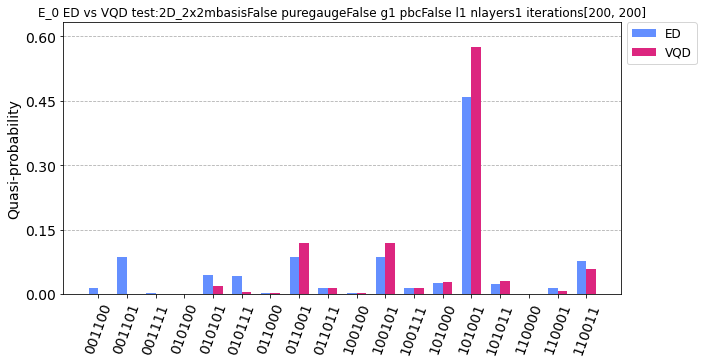

In [167]:
from qiskit.visualization import plot_histogram
plot_histogram([ed_val[0],vqd2_eigenstates[0]], figsize=(10,5),legend=['ED','VQD'] ,bar_labels=False,
               title=f'E_0 ED vs VQD test:{latt.dims}D_'+'x'.join(map(str,latt.n_sites))+f'mbasis{magnetic_basis} puregauge{puregauge} g{g} pbc{pbc} l{l} nlayers{nlayers} iterations{iterations}')
               #,filename='ansatz_tests/'+f'E_0_ED_vs_VQD_test:{latt.dims}D_'+'x'.join(map(str,latt.n_sites))+f'mbasis{magnetic_basis}_puregauge{puregauge}_g{g}_pbc{pbc}_l{l}_nlayers{nlayers}_iterations{iterations}')


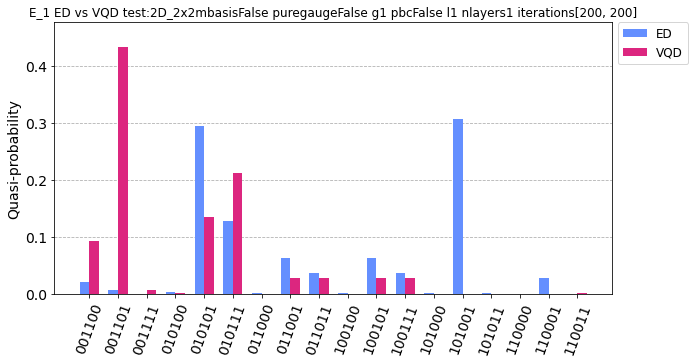

In [191]:
plot_histogram([ed_val[1],vqd2_eigenstates[1]], figsize=(10,5),legend=['ED','VQD'] ,bar_labels=False,
               title=f'E_1 ED vs VQD test:{latt.dims}D_'+'x'.join(map(str,latt.n_sites))+f'mbasis{magnetic_basis} puregauge{puregauge} g{g} pbc{pbc} l{l} nlayers{nlayers} iterations{iterations}')
               #,filename='ansatz_tests/'+f'E_1_ED_vs_VQD_test:{latt.dims}D_'+'x'.join(map(str,latt.n_sites))+f'mbasis{magnetic_basis}_puregauge{puregauge}_g{g}_pbc{pbc}_l{l}_nlayers{nlayers}_iterations{iterations}')